# Домашнее задание по теме «Элементарные методы анализа временных рядов»

## Задание
1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit

## Загрузка данных

In [6]:
airlines_passengers = pd.read_csv('../01 Знакомство с временными рядами/monthly-sales-of-company-x-jan-6.csv')
robberies_in_boston = pd.read_csv('../01 Знакомство с временными рядами/monthly-boston-armed-robberies-j.csv')
airlines_passengers = pd.read_csv('../01 Знакомство с временными рядами/international-airline-passengers.csv')
mean_monthly_temp = pd.read_csv('../01 Знакомство с временными рядами/mean-monthly-air-temperature-deg.csv')
dowjones_closing = pd.read_csv('../01 Знакомство с временными рядами/weekly-closings-of-the-dowjones-.csv')
female_births = pd.read_csv('../01 Знакомство с временными рядами/daily-total-female-births-in-cal.csv')

### Функция теста Дики-Фуллера

In [8]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### Функция Коррелограммы

In [10]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### Анализ временных рядов

Один из способов проверить, является ли временной ряд стационарным, — это выполнить расширенный тест Дики-Фуллера, в котором используются следующие нулевая и альтернативная гипотезы:

H0 : Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

H1 : временной ряд является стационарным.

#### Анализ временного ряда airlines_passengers

In [14]:
airlines_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   144 non-null    object
 1   Count   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [15]:
airlines_passengers = airlines_passengers['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


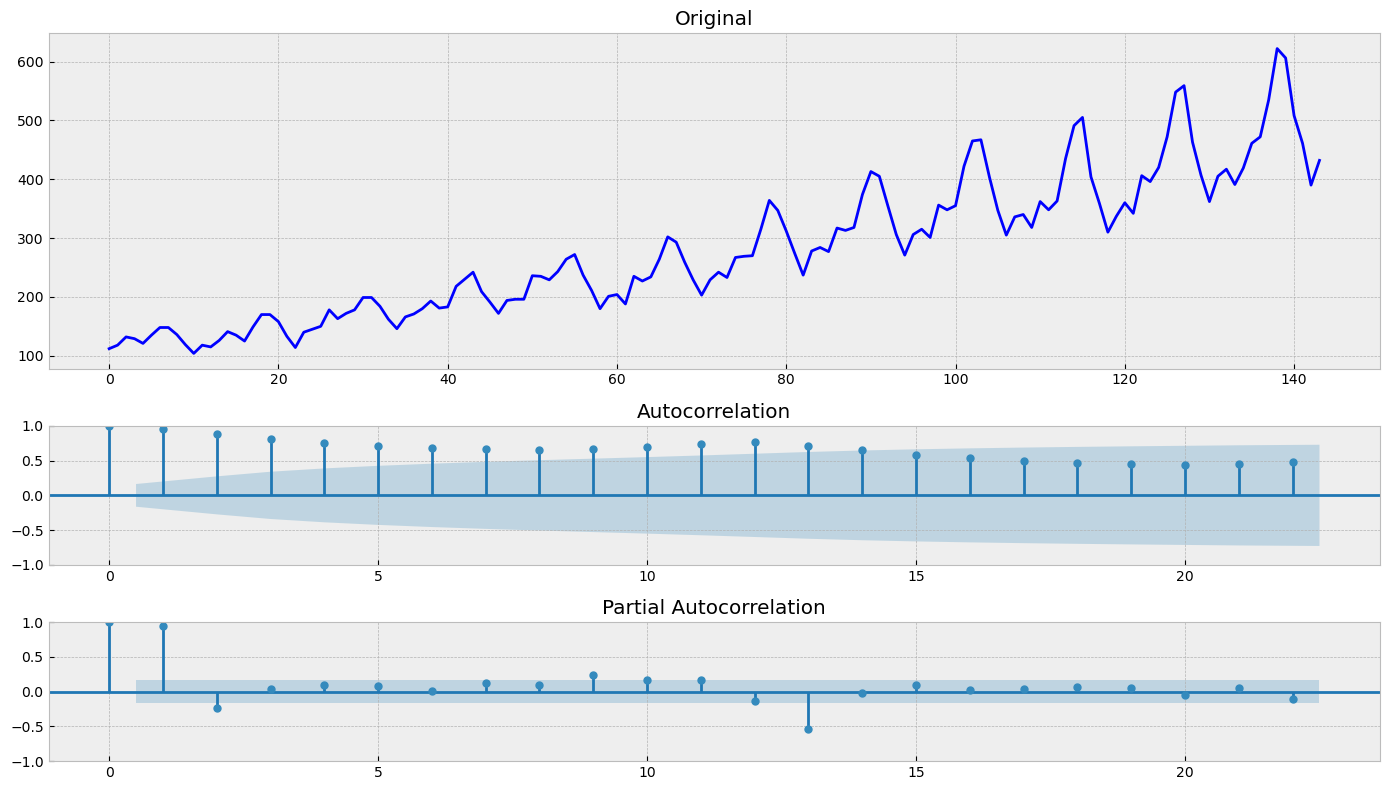

In [16]:
tsplot(airlines_passengers)

Поскольку p-значение не меньше 0,05, мы не можем отвергнуть нулевую гипотезу.
Ряд является нестационарным.

### Скользящие средние

In [19]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [20]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [21]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

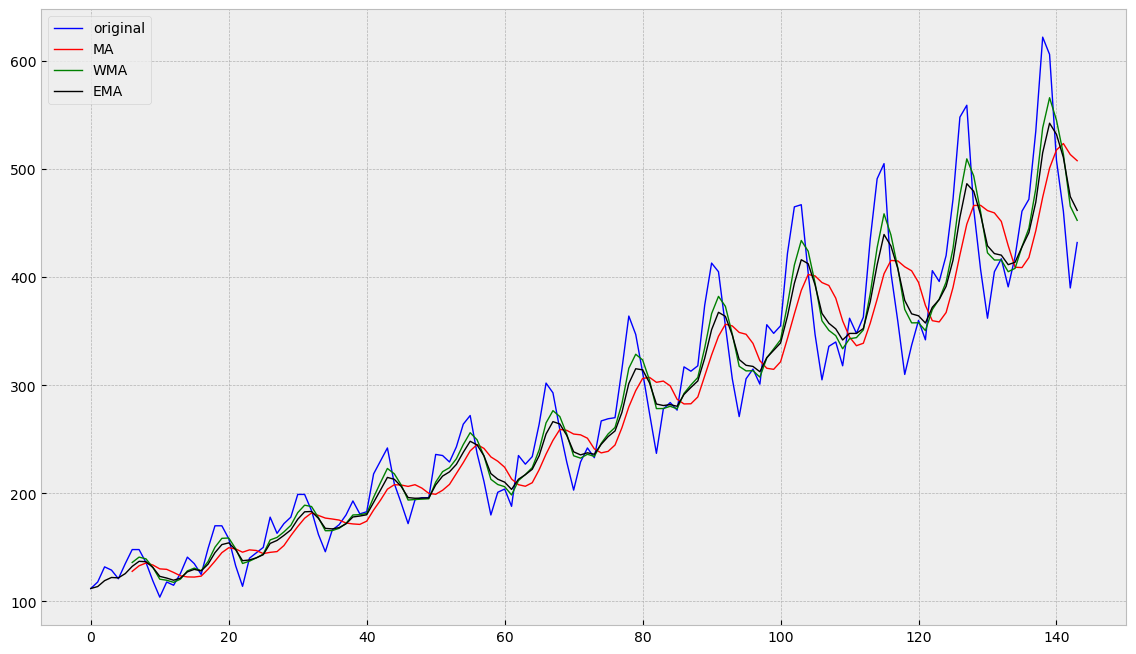

In [22]:
ma = moving_average(airlines_passengers, 7)
wma = weighted_moving_average(airlines_passengers, 7, [1,1,2,3,5,8,13])
ema = exponential_moving_average(airlines_passengers, 0.3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers, color='blue', linewidth='1', label='original')
    plt.plot(ma, color='red', linewidth='1', label='MA')
    plt.plot(wma, color='green', linewidth='1', label='WMA')
    plt.plot(ema, color='black', linewidth='1', label='EMA')
    plt.legend()

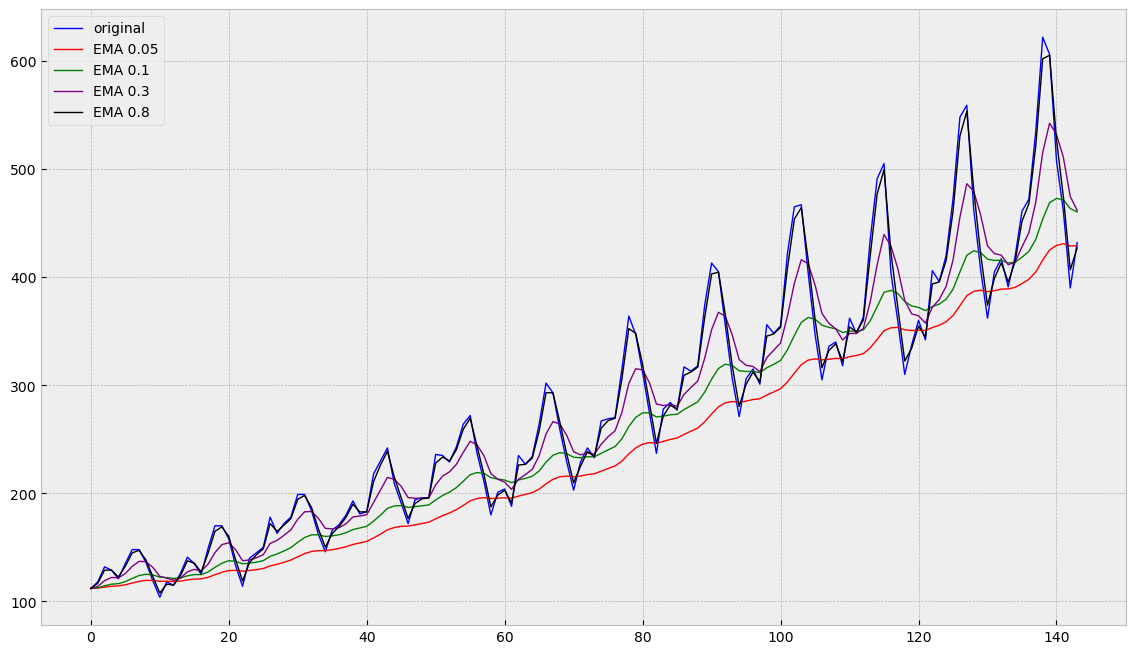

In [23]:
alphas = [0.05, 0.1, 0.3, 0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers, color='blue', linewidth='1', label='original')
    for i in range(len(alphas)):
        ser_ema = exponential_moving_average(airlines_passengers, alphas[i])
        plt.plot(ser_ema, color=colors[i], linewidth='1', label='EMA {}'.format(alphas[i]))
    plt.legend()

из-за сезонности применим метод Хольта-Винтерса

In [25]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [26]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [27]:

def triple_exponential_smoothing(ser_tma, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(ser_tma, slen)
    for i in range(len(ser_tma)+n_preds):
        if i == 0: # initial values
            smooth = ser_tma[0]
            trend = initial_trend(ser_tma, slen)
            result.append(ser_tma[0])
            continue
        if i >= len(ser_tma): # we are forecasting
            m = i - len(ser_tma) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = ser_tma[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [28]:
def plot_tema(alpha, beta, gamma, ser_tema=airlines_passengers, ser_to_plot=airlines_passengers, n_preds=24):
    tema = triple_exponential_smoothing(airlines_passengers, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue', linewidth='1', label='original')
        plt.plot(tema, color='red', linewidth='1', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

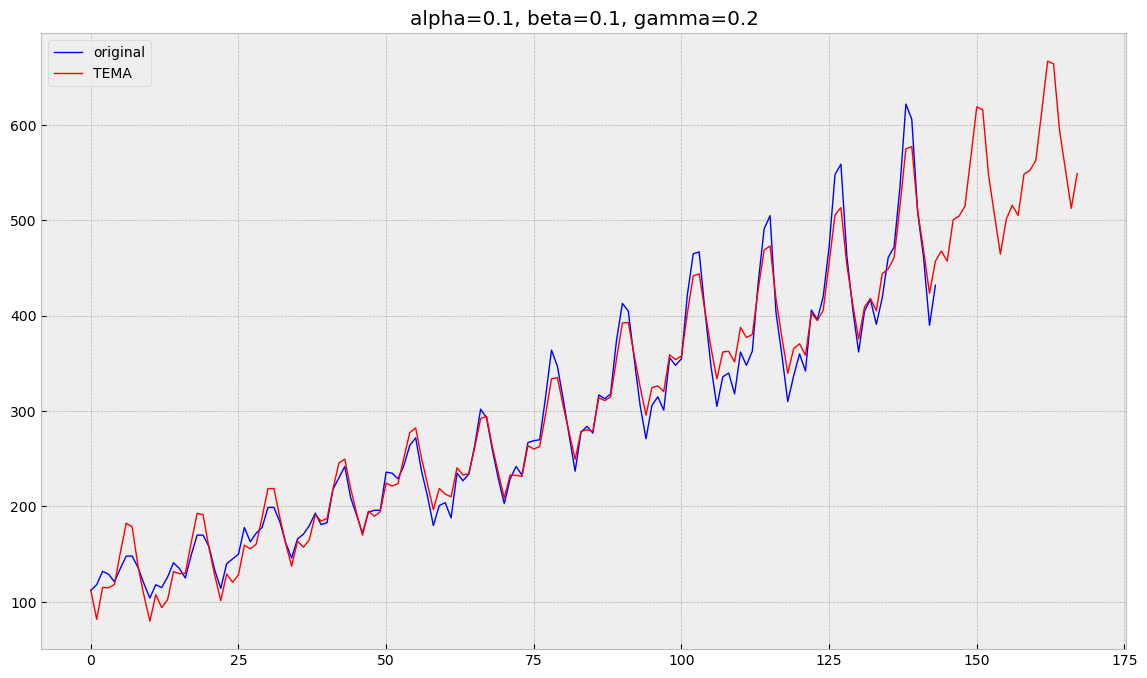

In [29]:
plot_tema(0.1, 0.1, 0.2)

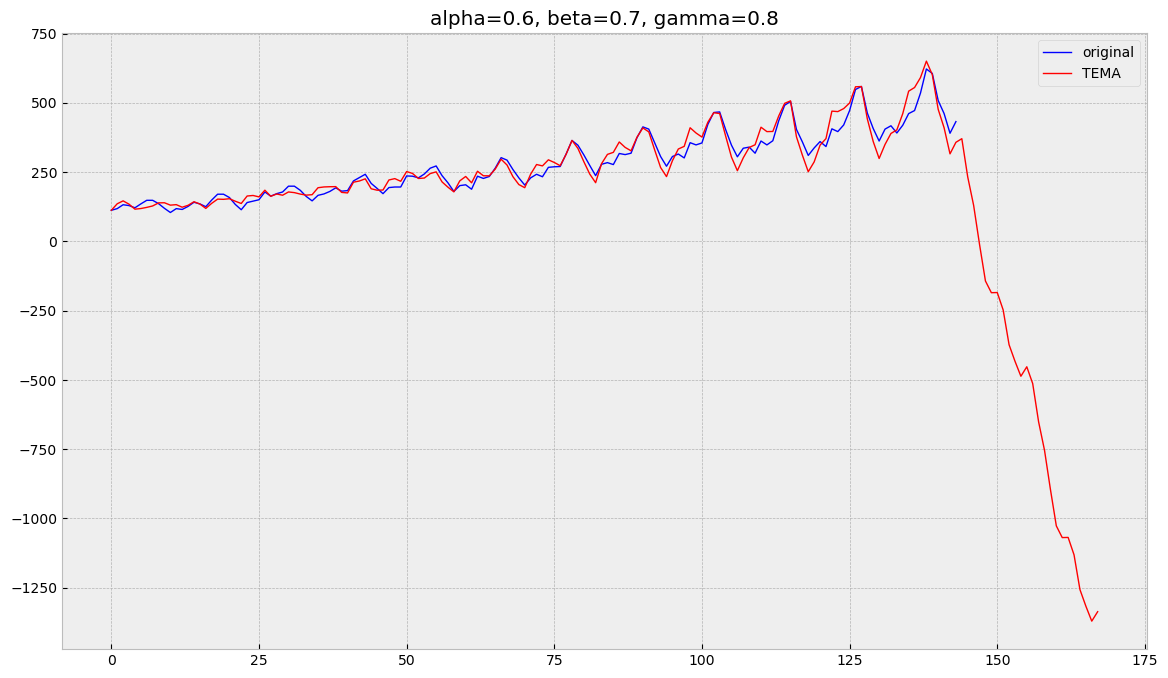

In [30]:
plot_tema(0.6, 0.7, 0.8)

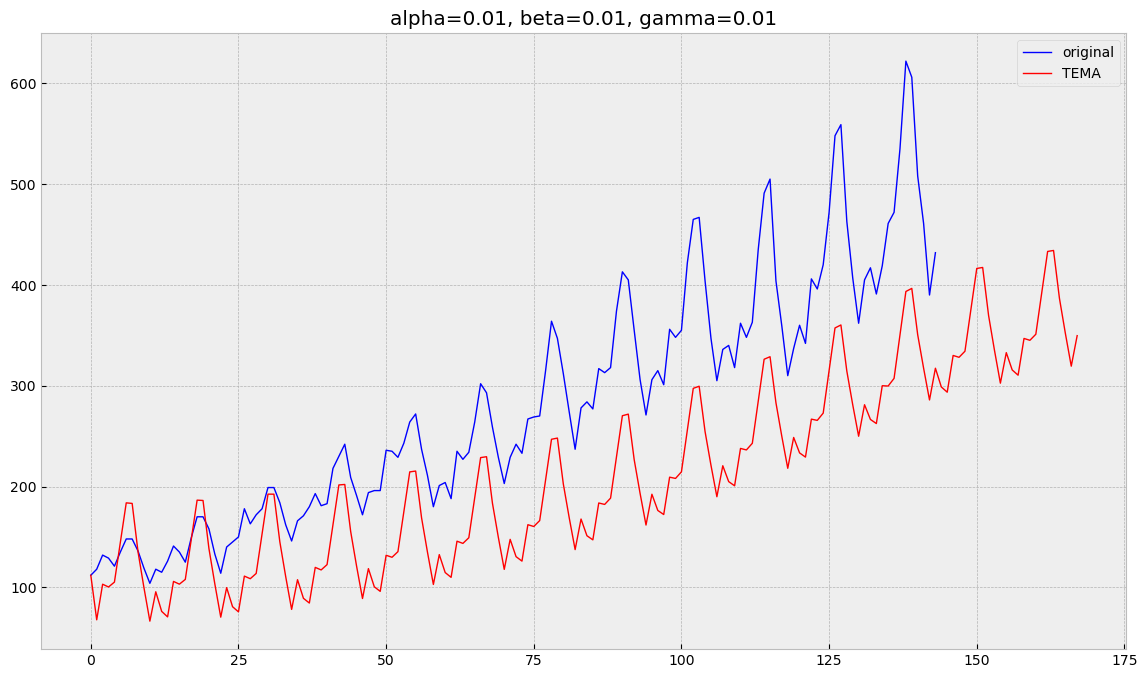

In [31]:
plot_tema(0.01, 0.01, 0.01)

Необходимо найти оптимальные параметры ТЕМА

In [33]:
len(airlines_passengers)

144

In [34]:
train, test, val = airlines_passengers[:120], airlines_passengers[120:140], airlines_passengers[140:]

In [35]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [36]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [37]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8851.628972820714
        x: [ 9.833e-01  1.610e-02  1.000e+00]
      nit: 14
      jac: [ 9.095e-04  7.340e-01  3.535e+00]
     nfev: 64
     njev: 16
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


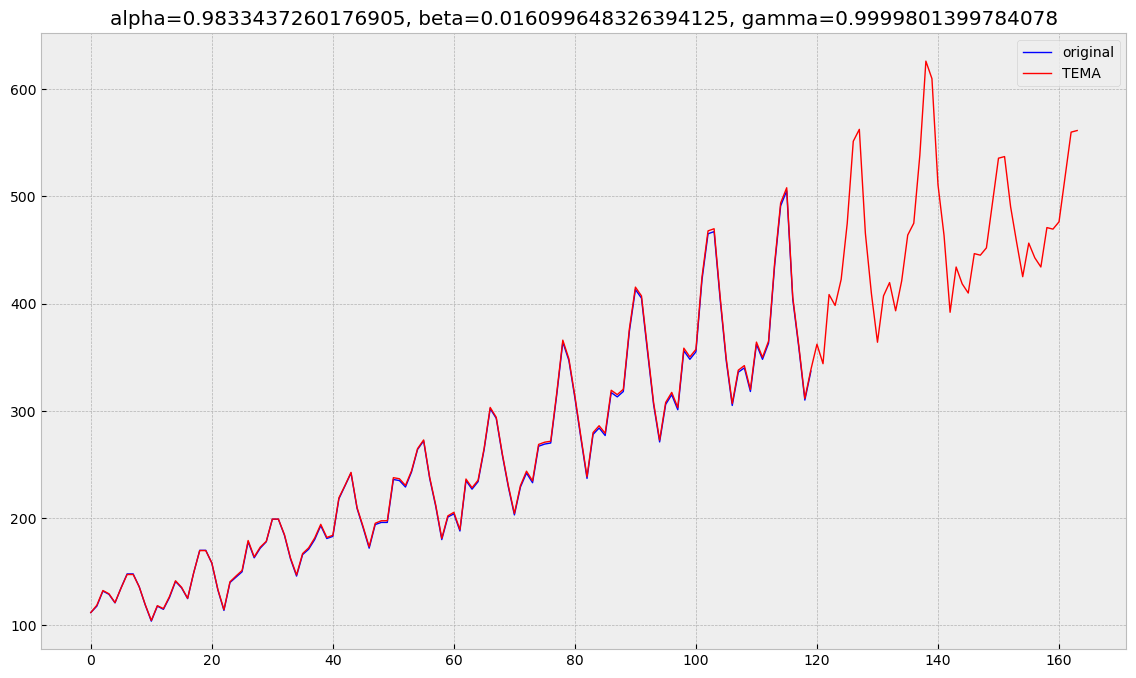

In [38]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=airlines_passengers[:120], n_preds=len(test))

In [40]:
train, val = airlines_passengers[:120], airlines_passengers[120:]

In [41]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [42]:
opt = minimize(mse_cross_val, x0=[0,0,0], method = "L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

32928.6067433389------------
32928.58885045783------------
32928.6067433389------------
32928.6052888951------------
2828.6301998771737------------
2828.6301941789134------------
2828.6287229856266------------
2828.6301998771737------------
5499.817875877975------------
5499.817853140885------------
5499.81852731328------------
5499.817875877975------------
2289.86512075859------------
2289.8651086264526------------
2289.8653950933362------------
2289.86512075859------------
2194.993316842359------------
2194.9933281468852------------
2194.9935246721293------------
2194.9933168420503------------
2166.948241375718------------
2166.9482495894986------------
2166.947976212008------------
2166.9482413736037------------
2116.3159426073503------------
2116.3159526548197------------
2116.3160133820384------------
2116.3159426074803------------
2110.031481503002------------
2110.0314907984175------------
2110.0314447252663------------
2110.031481502297------------
2108.2047832932335-----------

In [43]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 473.1564669421975
        x: [ 7.231e-02  1.019e-01  1.000e+00]
      nit: 27
      jac: [ 4.349e-03  5.122e-03 -4.335e+01]
     nfev: 156
     njev: 39
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


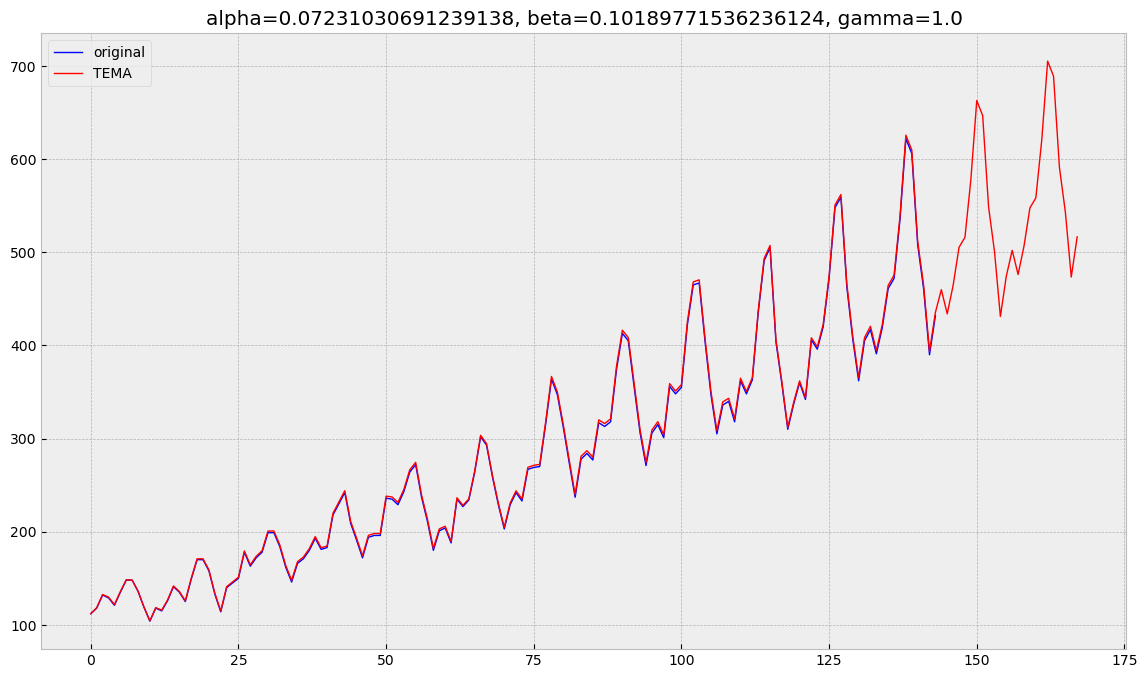

In [44]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=airlines_passengers, n_preds=len(val))

Получилось хорошее предсказание нестационарного ряда

### ТЕМА для стационарного ряда

In [48]:
airlines_passengers = boxcox(airlines_passengers, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


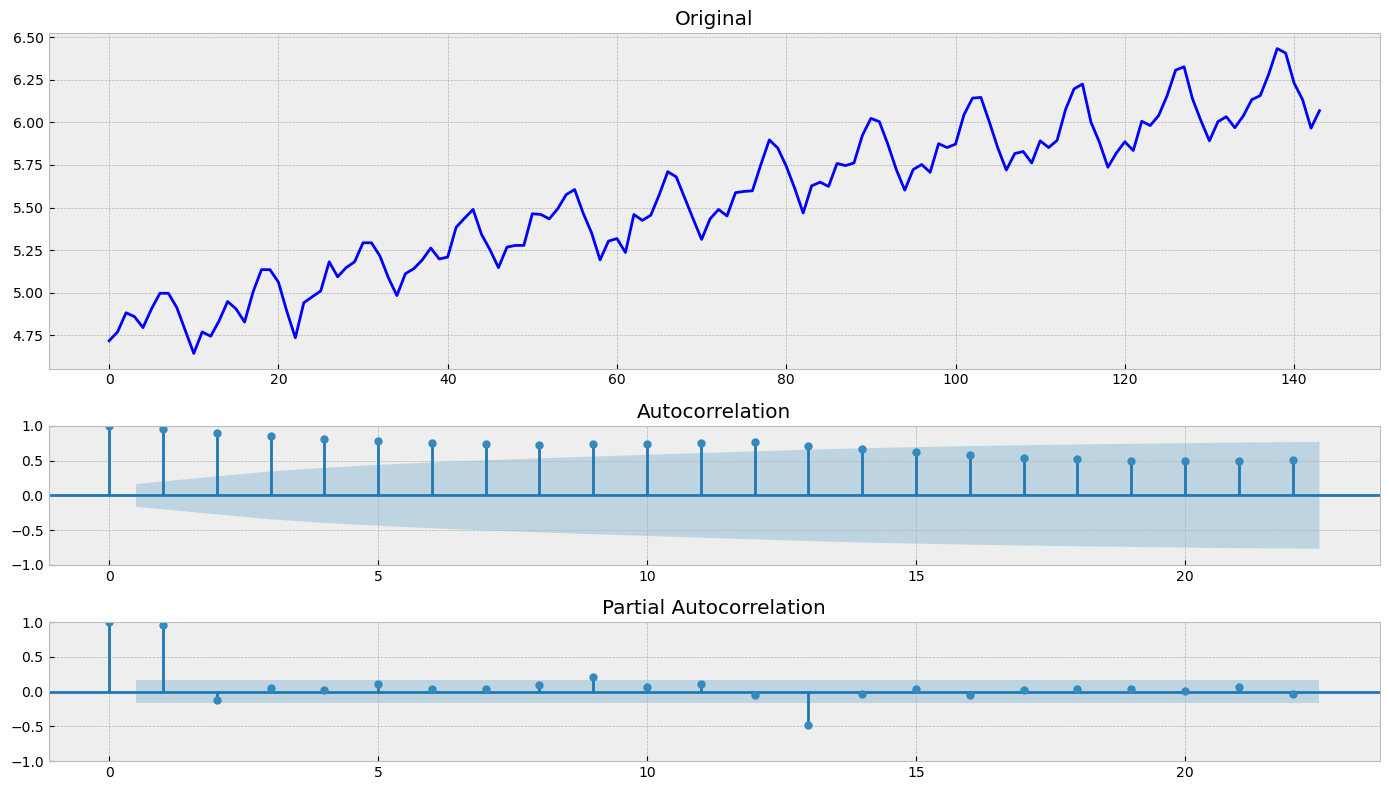

In [49]:
tsplot(airlines_passengers)

In [50]:
airlines_passengers = airlines_passengers[1:] - airlines_passengers[:-1]

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


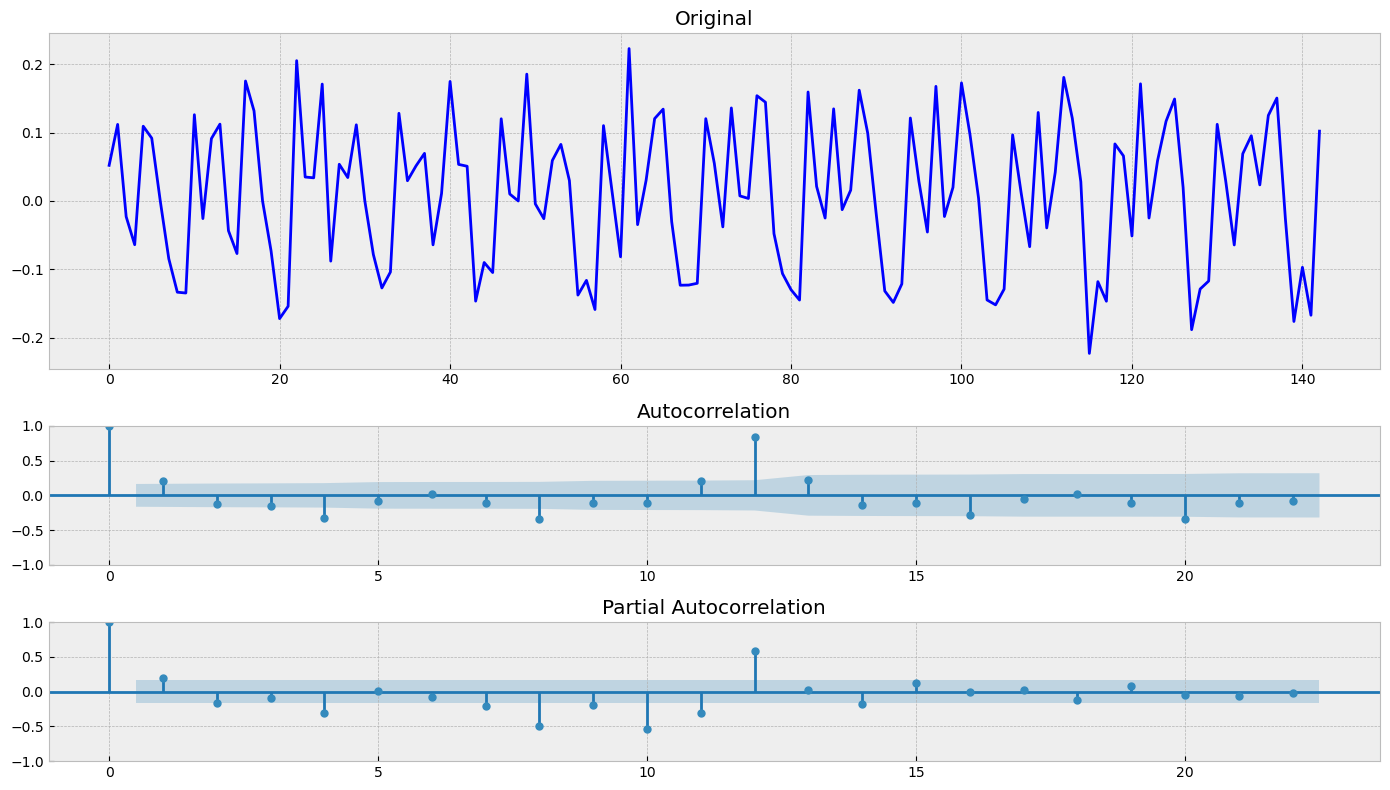

In [51]:
tsplot(airlines_passengers)

In [52]:
airlines_passengers = airlines_passengers[12:] - airlines_passengers[:-12]

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


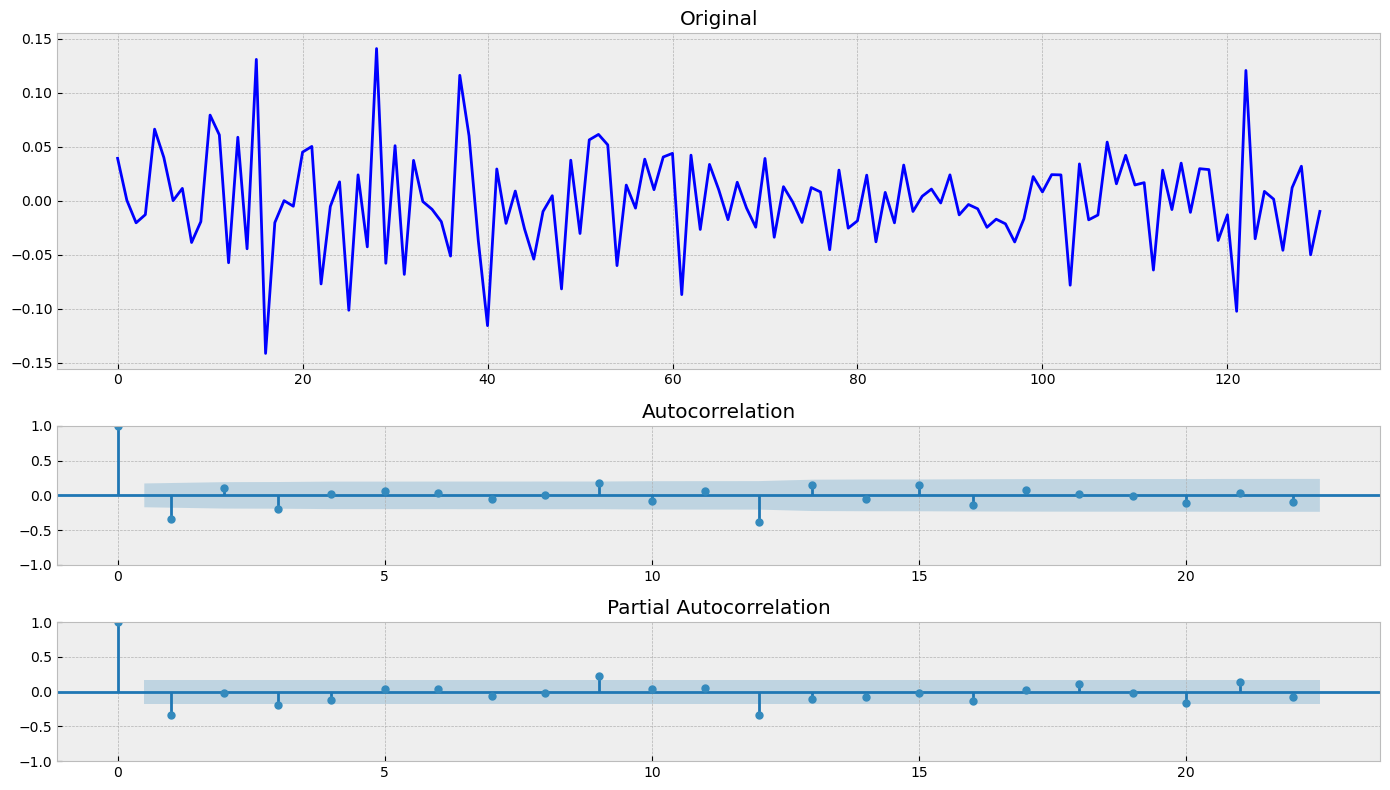

In [53]:
tsplot(airlines_passengers)

теперь ряд стационарный

In [55]:
len(airlines_passengers)

131

In [56]:
train, test, val = airlines_passengers[:120], airlines_passengers[120:130], airlines_passengers[130:]

In [57]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [58]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [59]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.003435877167574982
        x: [ 4.872e-01  5.400e-03  1.437e-01]
      nit: 15
      jac: [ 3.807e-07  7.815e-06 -4.809e-07]
     nfev: 92
     njev: 23
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


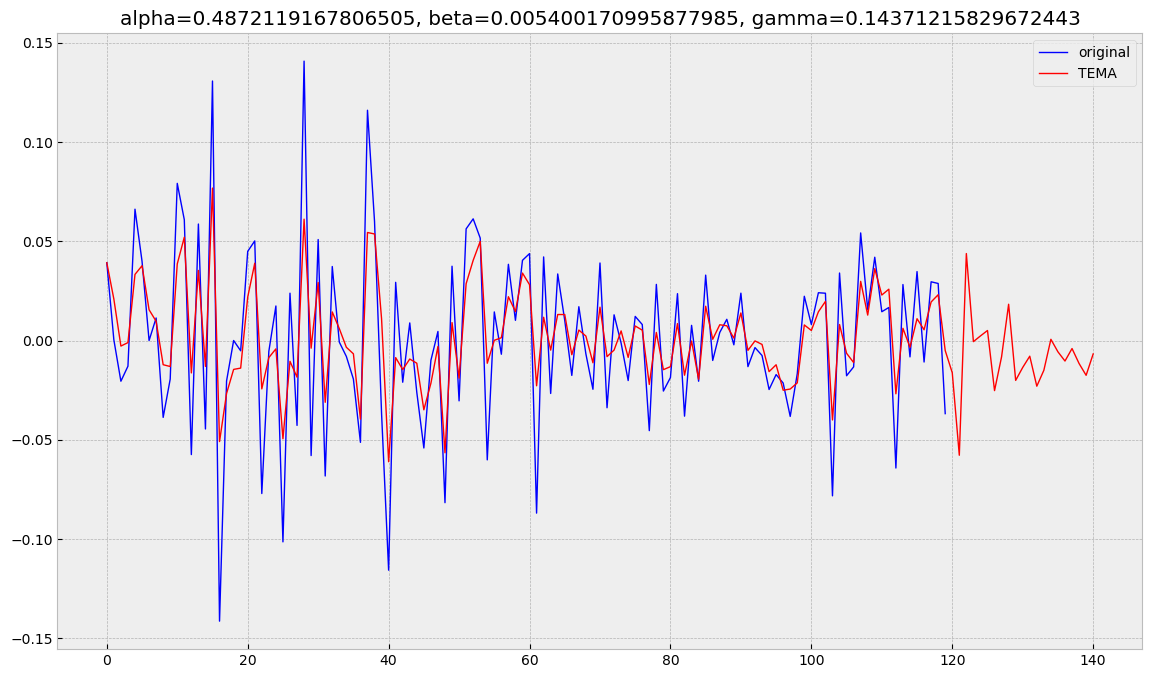

In [60]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=airlines_passengers[:120], n_preds=len(test))

Для стационарного ряда предсказание получилось хуже. Без сезонности ТЕМА работает плохо. Лучше не приводить ряд к стационарности